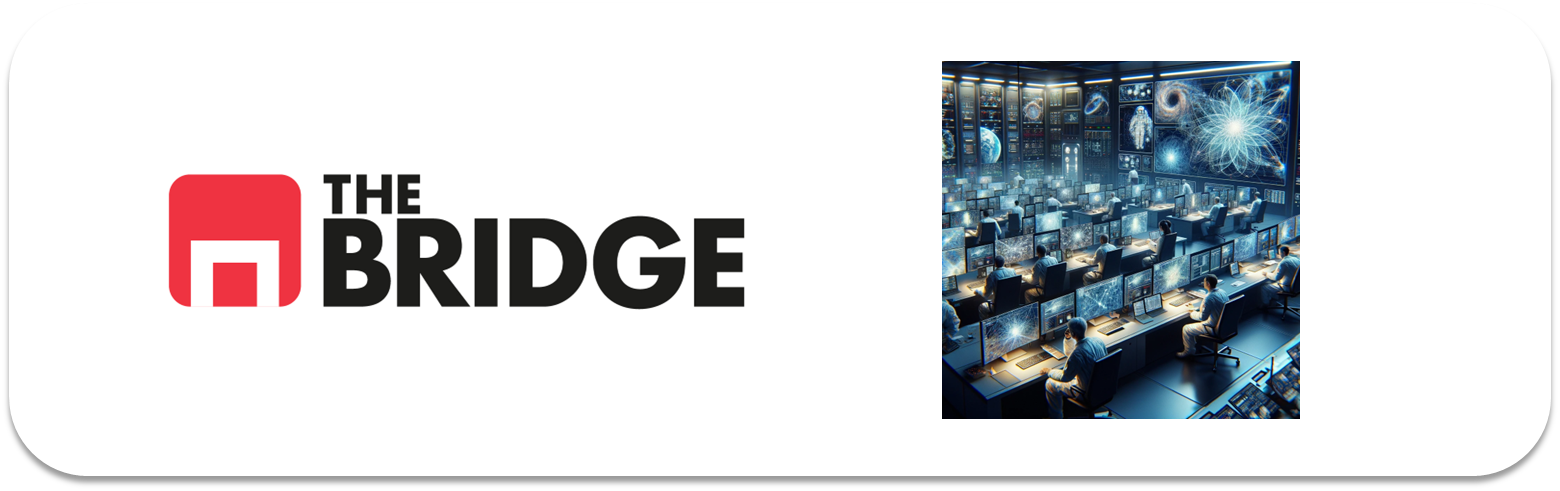

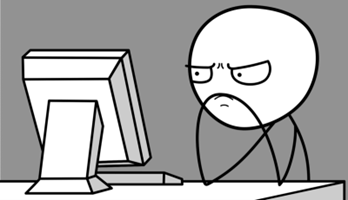

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [84]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras



from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
from cv2 import imread

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [41]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [42]:
ROOT_PATH = './data/apples/'
TRAIN_PATH = ROOT_PATH + "Train/"
TEST_PATH = ROOT_PATH + "Test/"

In [43]:
X_train,y_train= read_data(TRAIN_PATH)

In [44]:
X_train.shape

(6404, 32, 32, 3)

In [45]:
y_train.shape

(6404,)

In [46]:
X_test,y_test= read_data(TEST_PATH)

In [47]:
print(X_test.shape)
print(y_test.shape)

(2134, 32, 32, 3)
(2134,)


In [48]:
X_test_ultra,y_test_ultra= read_data(TEST_PATH,(224,224))

In [49]:
print(X_test_ultra.shape)
print(y_test_ultra.shape)

(2134, 224, 224, 3)
(2134,)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

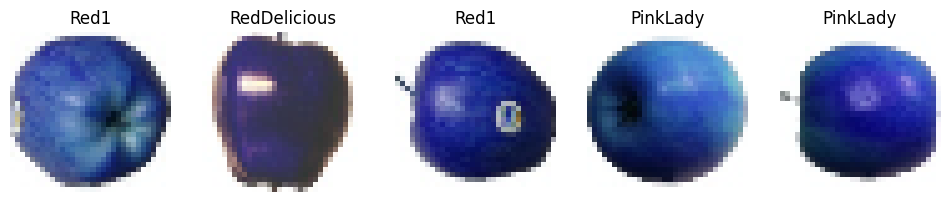

In [50]:
fig,ax=plt.subplots(1,5, figsize=(12,4))
for i, index in enumerate(np.random.choice(len(X_train), size=5)):
    ax[i].imshow(X_train[index])
    ax[i].set_title(y_train[index])
    ax[i].axis("off")

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [51]:
print(pd.Series(y_train).value_counts())

RedYellow2      672
Braeburn        492
Golden2         492
GrannySmith     492
Red1            492
Red2            492
RedYellow1      492
RedDelicious    490
Golden3         481
Golden1         480
PinkLady        456
CrimsonSnow     444
Red3            429
Name: count, dtype: int64


In [52]:
#Escojo accuracy

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [53]:
X_train = X_train / 255.
X_test = X_test / 255.
X_test_ultra = X_test_ultra / 255.

In [54]:
from sklearn.utils import shuffle
X_train_shuf, y_train_shuf = shuffle(X_train, y_train, random_state=42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [55]:
mapping_apples = {'RedYellow2': 0, 'Braeburn': 1, 'Golden2': 2, 'GrannySmith': 3, 'Red1': 4, 'Red2': 5, 'RedYellow1': 6, 
                  'RedDelicious': 7, 'Golden3': 8, 'Golden1': 9, 'PinkLady': 10, 'CrimsonSnow': 11, 'Red3': 12}

mapping_apples_inverso = {v: k for k, v in mapping_apples.items()}

In [56]:
y_train_shuf= pd.Series(y_train_shuf).map(mapping_apples)

In [106]:
y_test= pd.Series(y_test).map(mapping_apples)

In [57]:
y_train_shuf.value_counts()

0     672
3     492
6     492
2     492
1     492
5     492
4     492
7     490
8     481
9     480
10    456
11    444
12    429
Name: count, dtype: int64

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [58]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [59]:
seleccion_aleat=np.random.choice(len(X_test), size=15)
selec_X_test= X_test_ultra[seleccion_aleat]
selec_X_test

array([[[[0.98431373, 1.        , 1.        ],
         [0.98431373, 1.        , 1.        ],
         [0.98431373, 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.98431373, 1.        , 1.        ],
         [0.98431373, 1.        , 1.        ],
         [0.98431373, 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.98431373, 1.        , 1.        ],
         [0.98431373, 1.        , 1.        ],
         [0.98823529, 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [60]:
base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

In [63]:
def plot_image(i, class_predicted, class_prob, true_label, img):
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  plt.xlabel(f"{class_predicted} {class_prob:.2f} ({true_label})")

def plot_value_array(predictions_array, predictions_labels):
  #predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_labels)),labels = predictions_labels)
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  plt.xlabel("top-5 predicciones")

  #thisplot[predicted_label].set_color('red')
  #thisplot[true_label].set_color('blue')

In [65]:
num_rows = len(selec_X_test)
num_cols = 1
num_images = num_rows * num_cols

#plt.figure(figsize=(40, 40))

preds = base_model.predict(selec_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


C:\Users\Guillermo\AppData\Local\Temp\ipykernel_13736\1420990720.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(40, 40))


IndexError: list index out of range

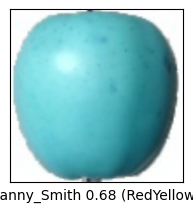

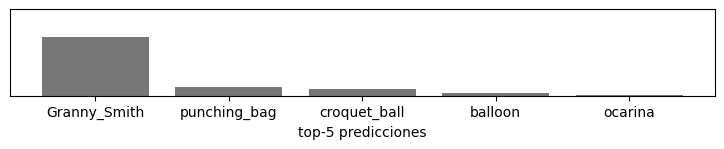

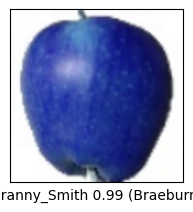

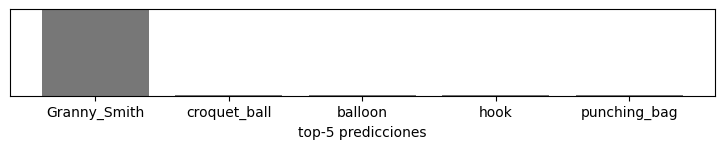

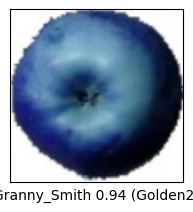

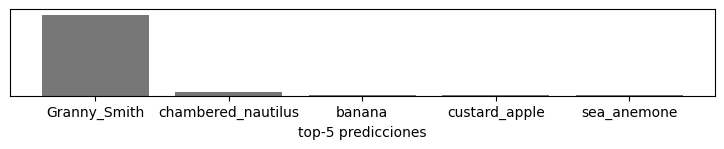

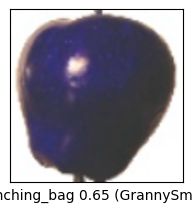

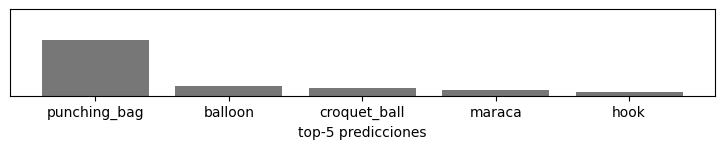

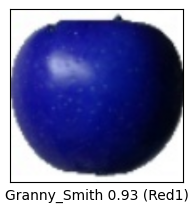

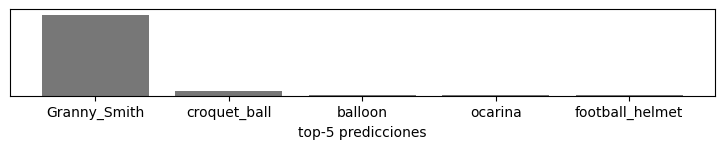

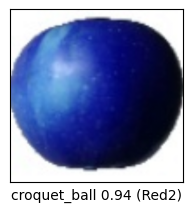

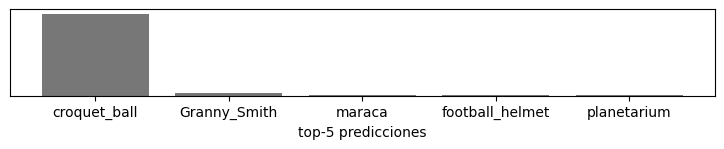

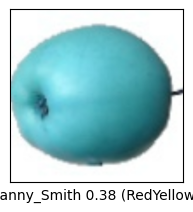

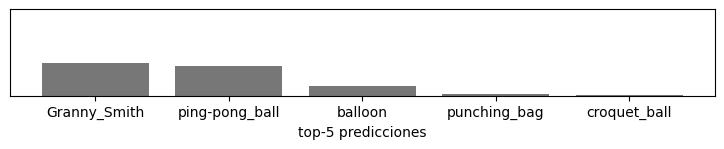

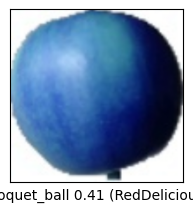

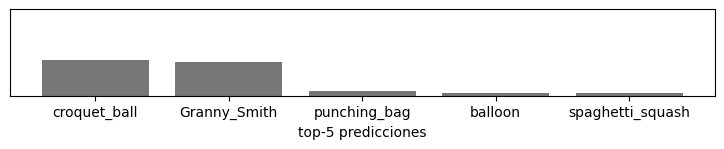

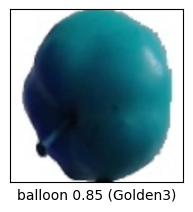

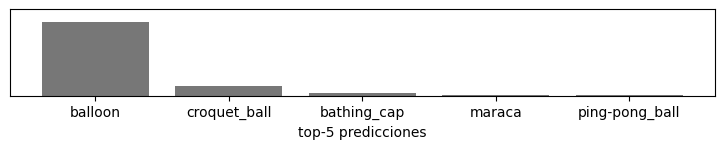

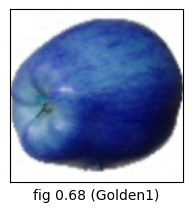

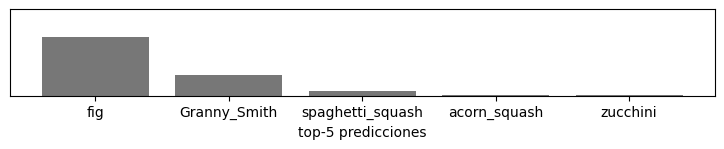

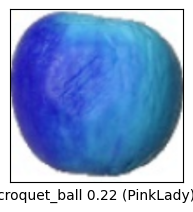

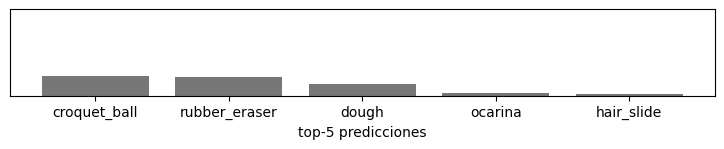

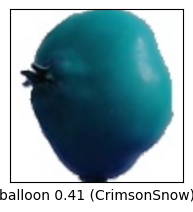

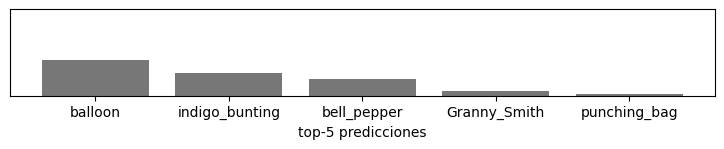

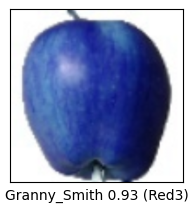

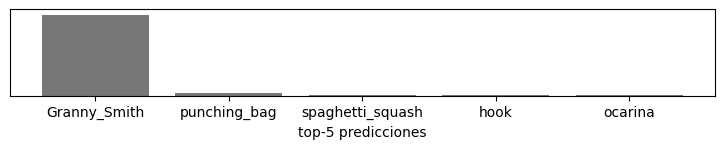

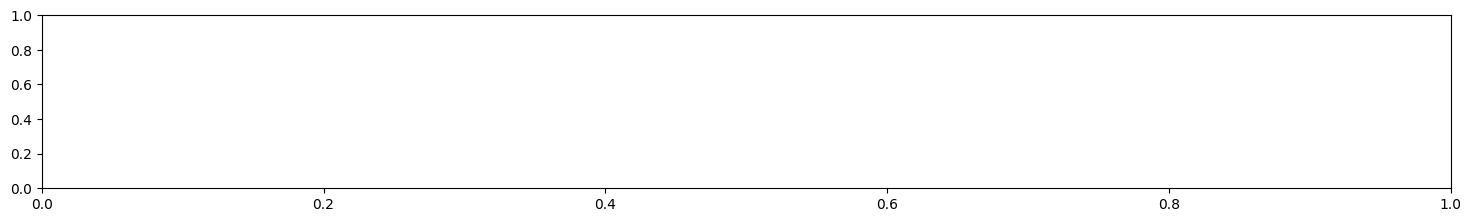

In [75]:
decodes = decode_predictions(preds, top=5)

for i,j in enumerate(decodes):
    prediction_proba = []
    predicted_classes = []
    for decode in j:
        prediction_proba.append(decode[2])
        predicted_classes.append(decode[1])
    plt.figure(figsize=(40, 40))
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i,predicted_classes[0],prediction_proba[0],list(mapping_apples.keys())[i],selec_X_test)
    plt.figure(figsize=(20, 20))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(prediction_proba, predicted_classes)
plt.tight_layout()
plt.show()

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [125]:
transfer_model = ResNet50V2(input_shape=(32, 32,3),
                        include_top=False,
                        weights="imagenet")

In [126]:
for layer in transfer_model.layers:
    layer.trainable = False

In [127]:
x = layers.Flatten()(transfer_model.output) 
x = layers.Dense(300, activation='relu')(x)
x = layers.Dense(13, activation='softmax')(x)

model = tf.keras.models.Model(transfer_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [128]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [129]:
checkpoint=keras.callbacks.ModelCheckpoint("checkpoint_model.keras")
early_stop=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
history = model.fit(X_train_shuf, y_train_shuf,validation_split = 0.2,batch_size=64, epochs = 10, callbacks=[checkpoint,early_stop])

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.6596 - loss: 1.2096 - val_accuracy: 0.9680 - val_loss: 0.1642
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.9832 - loss: 0.1045 - val_accuracy: 0.9828 - val_loss: 0.0740
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.9875 - loss: 0.0568 - val_accuracy: 0.9984 - val_loss: 0.0318
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 0.9994 - loss: 0.0192 - val_accuracy: 0.9992 - val_loss: 0.0129
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.9986 - loss: 0.0137 - val_accuracy: 0.9984 - val_loss: 0.0105
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.9999 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accu

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [130]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8602 - loss: 0.3940
test loss, test acc: [0.4130139946937561, 0.8598875403404236]


In [131]:
y_pred_probs=model.predict(X_test)
y_pred = [np.argmax(prediction) for prediction in  y_pred_probs]

67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step


In [132]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       219
           1       0.66      0.81      0.73       164
           2       0.98      0.77      0.86       164
           3       0.96      0.85      0.90       164
           4       1.00      0.82      0.90       164
           5       0.63      0.80      0.71       164
           6       0.90      0.98      0.94       164
           7       1.00      1.00      1.00       166
           8       0.62      0.64      0.63       161
           9       0.83      0.99      0.90       160
          10       0.93      0.83      0.88       152
          11       0.95      0.95      0.95       148
          12       0.94      0.73      0.82       144

    accuracy                           0.86      2134
   macro avg       0.87      0.86      0.86      2134
weighted avg       0.88      0.86      0.86      2134



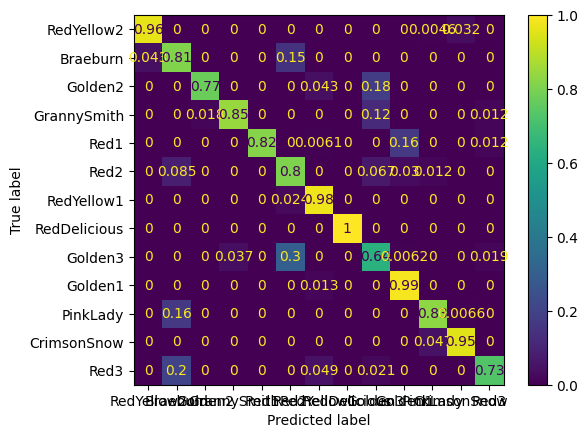

In [139]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,normalize="true",display_labels=mapping_apples)

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [141]:
tuning_model = ResNet50V2(input_shape=(32, 32,3),
                        include_top=False,
                        weights=None)

x = layers.Flatten()(tuning_model.output) 
x = layers.Dense(300, activation='relu')(x)
x = layers.Dense(13, activation='softmax')(x)

model = tf.keras.models.Model(tuning_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [142]:
checkpoint=keras.callbacks.ModelCheckpoint("checkpoint_model_tuning.keras")
early_stop=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
tuning_history = model.fit(X_train_shuf, y_train_shuf,validation_split = 0.2,batch_size=64, epochs = 60, callbacks=[checkpoint,early_stop])

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 99s 892ms/step - accuracy: 0.7275 - loss: 0.8446 - val_accuracy: 0.0952 - val_loss: 3.0725
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 66s 819ms/step - accuracy: 0.9226 - loss: 0.2749 - val_accuracy: 0.0765 - val_loss: 4.2784
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 66s 821ms/step - accuracy: 0.9545 - loss: 0.1723 - val_accuracy: 0.0695 - val_loss: 11.0787
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 888ms/step - accuracy: 0.9408 - loss: 0.2138 - val_accuracy: 0.0952 - val_loss: 8.8249
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 952ms/step - accuracy: 0.9242 - loss: 0.2484 - val_accuracy: 0.6378 - val_loss: 1.7923
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 886ms/step - accuracy: 0.9683 - loss: 0.1315 - val_accuracy: 0.8704 - val_loss: 0.5918
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 843ms/step - accuracy: 0.9876 - loss: 0.0521 - val_accuracy: 0.9586 - val_loss: 0.1158
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 857ms/step - accuracy: 0.9529 - loss: 0.1594 - val_acc

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [143]:
results_tun = model.evaluate(X_test, y_test)
print("test loss, test acc:", results_tun)

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9729 - loss: 0.1071
test loss, test acc: [0.19873277842998505, 0.9475163817405701]


In [147]:
y_pred_probs_tun=model.predict(X_test)
y_pred_tun = [np.argmax(prediction) for prediction in  y_pred_probs_tun]

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step


In [148]:
print(classification_report(y_test,y_pred_tun))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       219
           1       0.70      1.00      0.82       164
           2       0.82      1.00      0.90       164
           3       1.00      0.91      0.96       164
           4       0.99      0.86      0.92       164
           5       1.00      0.88      0.94       164
           6       1.00      1.00      1.00       164
           7       1.00      1.00      1.00       166
           8       1.00      1.00      1.00       161
           9       1.00      0.99      0.99       160
          10       0.99      1.00      0.99       152
          11       1.00      1.00      1.00       148
          12       1.00      0.65      0.78       144

    accuracy                           0.95      2134
   macro avg       0.96      0.94      0.95      2134
weighted avg       0.96      0.95      0.95      2134



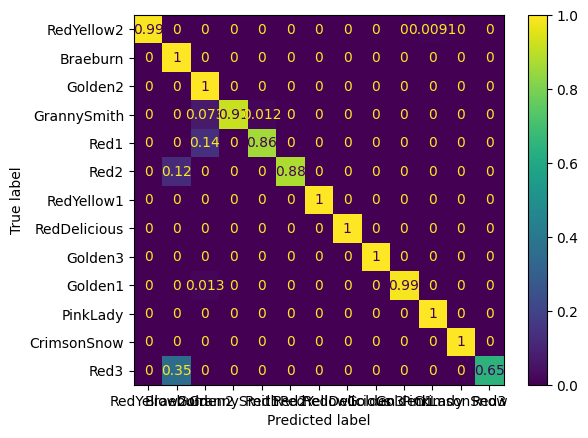

In [149]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tun,normalize="true",display_labels=mapping_apples)